In [89]:
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
import pandas as pd
import pygmt
import xarray as xr
import glob
import yaml

In [119]:
with open('gmt_config.yml', 'r') as ymlfile:
    map_cfg = yaml.safe_load(ymlfile)

In [6]:
west = pd.read_pickle('../data/processed/west_fgmax_points.pkl.gz')
central = pd.read_pickle('../data/processed/central_fgmax_pts.pkl.gz')
east = pd.read_pickle('../data/processed/east_fgmax_pts.pkl.gz')
surge_locs = np.array([west.columns[1], 
                       central.columns[1], 
                       east.columns[1]])
def split_tuple(value):
    location, number = value.strip('()').split(", ")
    return location, int(number)

In [129]:
pd.DataFrame(surge_locs)

,0,1
0,40.780139,-72.811713
1,40.804769,-72.731991
2,40.781250,-72.720880


In [7]:
gauge_locs = pd.read_csv('../data/plotting_gauges_locs.csv',
                        converters={'Unnamed: 0': split_tuple})
print(gauge_locs)
gauge_locs[['location', 'number']] = pd.DataFrame(gauge_locs['Unnamed: 0'].tolist(),
                                                  index=gauge_locs.index)
gauge_locs.drop('Unnamed: 0', axis=1, inplace=True)
gauge_locs['location'] = gauge_locs['location'].str.strip("'\'")
numbers_to_keep = [84,82,133, 45, 11, 119]
gauge_locs = gauge_locs[gauge_locs['number'].astype(int).isin(numbers_to_keep)]

location_mapping = {'west': ['a', 'b'],
                    'central': ['c', 'd'],
                    'east':['e', 'f']}
gauge_locs['new_column'] = ''
for location in location_mapping.keys():
    indices = gauge_locs[gauge_locs['location'] == location].index
    if len(indices) > 0:
        location_values = location_mapping[location]
        for i, index in enumerate(indices):
            value_index = i % len(location_values)
            gauge_locs.at[index, 'new_column'] = location_values[value_index]                                           

         Unnamed: 0       lon        lat
0      ('west', 84) -72.85546  40.740220
1      ('west', 82) -72.83375  40.753260
2      ('west', 80) -72.80720  40.764400
3   ('central', 79) -72.81200  40.778100
4  ('central', 133) -72.75266  40.781300
5   ('central', 45) -72.75000  40.786667
6      ('east', 11) -72.70000  40.795000
7     ('east', 105) -72.67050  40.798000
8     ('east', 119) -72.65900  40.797600


In [8]:
storm_track = pd.read_csv('/home/catherinej/BarrierBreach/data/NACCS_info/NACCS_TS_Sim0_Post0_ST_TROP_STcond.csv')
storm = storm_track.loc[storm_track['Storm ID'] == 486]
storm

,Storm Group,Storm Name,Storm ID,Storm Type,yyyymmddHHMM,Central Pressure (hPa),Far Field Pressure (hPa),Forward Speed (km/h),Heading (deg),Holland B1,Holland B2,Radius Max Winds (km),Radius Pressure 1 (km),Radius Pressure 2 (km),Storm Latitude (deg),Storm Longitude (deg)
79337,Region2_Landfall,Synthetic_0486,486,Tropical_Synthetic,NaN,965.0,1013,57.9676,-80,1.15,NaN,48.9388,59.8196,NaN,21.586,-53.899
79338,Region2_Landfall,Synthetic_0486,486,Tropical_Synthetic,NaN,965.0,1013,57.9676,-80,1.15,NaN,48.9388,59.8196,NaN,21.678,-54.452
79339,Region2_Landfall,Synthetic_0486,486,Tropical_Synthetic,NaN,965.0,1013,57.9676,-80,1.15,NaN,48.9388,59.8196,NaN,21.771,-55.005
79340,Region2_Landfall,Synthetic_0486,486,Tropical_Synthetic,NaN,965.0,1013,57.9676,-80,1.15,NaN,48.9388,59.8196,NaN,21.866,-55.558
79341,Region2_Landfall,Synthetic_0486,486,Tropical_Synthetic,NaN,965.0,1013,57.9676,-80,1.15,NaN,48.9388,59.8196,NaN,21.963,-56.111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79405,Region2_Landfall,Synthetic_0486,486,Tropical_Synthetic,NaN,972.9,1013,57.9676,0,1.12,NaN,52.4780,65.0052,NaN,44.856,-73.320
79406,Region2_Landfall,Synthetic_0486,486,Tropical_Synthetic,NaN,973.6,1013,57.9676,0,1.12,NaN,52.8534,65.5608,NaN,45.378,-73.323
79407,Region2_Landfall,Synthetic_0486,486,Tropical_Synthetic,NaN,974.2,1013,57.9676,0,1.11,NaN,53.2281,66.1164,NaN,45.900,-73.325
79408,Region2_Landfall,Synthetic_0486,486,Tropical_Synthetic,NaN,974.8,1013,57.9676,0,1.11,NaN,53.6021,66.6720,NaN,46.422,-73.328


In [80]:
def create_breach_loc_mesh(name, breaches):
    with open(f"{name}_mesh.dat", "w") as fp:
        for _, row in breaches.iterrows():
            # Extract coordinates for the polygon
            lon, lat = row['Mu'], (row['South'] + row['North'])/2
            # print(_, depth)

            fp.write(f"{lon} {lat}\n")
            
breaches = pd.read_pickle(f'breach_data_updated.pkl.gz')  # Assuming breach data files follow this naming convention
mesh_name = 'w_0486_6'
create_breach_loc_mesh(mesh_name, breaches[breaches['key'] == mesh_name])


In [160]:
inset_annotations = {'Storm Track': {'lon': -72.90, 'lat': 40.50, 'font': '8p,Times-Roman,black', 'pen':'0.5p,#56B4E9', 'angle': 0,'fill':'white'},
                     'Moriches Bay, NY': {'lon': -72.0, 'lat':40.70, 'font': '8p,Times-Roman,black', 'pen':'0.5p,#D55E00', 'angle':0, 'fill':'white'},
                     'Long Island, NY' : {'lon': -73.31, 'lat': 40.78, 'font':'8p,Times-Roman,black', 'pen': '0.5p,black', 'angle': 18, 'fill':'white'},
                     'New Jersey': {'lon': -74.5, 'lat': 40.7178, 'font':'8p,Times-Roman,black', 'pen': '0.5p,black', 'angle': 0, 'fill':'white'},
                     'New York': {'lon': -74., 'lat': -41.65, 'font':'8p,Times-Roman,black', 'pen': '0.5p,black', 'angle': 0, 'fill':'white'},
                     'Connecticut': {'lon': -73.0877, 'lat': 41.6032, 'font':'8p,Times-Roman,black', 'pen': '0.5p,black', 'angle': 0, 'fill':'white'},
}


# Extract data into arrays
lon = np.array([props['lon'] for props in inset_annotations.values()])
lat = np.array([props['lat'] for props in inset_annotations.values()])
angle = np.array([props['angle'] for props in inset_annotations.values()])
font = np.array([props['font'] for props in inset_annotations.values()])
pen = np.array([props['pen'] for props in inset_annotations.values()])
labels = np.array(list(inset_annotations.keys()))
fill = np.array([props['fill'] for props in inset_annotations.values()])


In [167]:
pen

array(['0.5p,#56B4E9', '0.5p,#D55E00', '0.5p,black', '0.5p,black',
       '0.5p,black', '0.5p,black'], dtype='<U12')

In [161]:
 annot_locs = {'Forge River': [-72.83288, 40.80620986-0.025],
                  'Seatuck Cove': [-72.7260 - .02, 40.8094],
               # 'Moriches': [-72.8225, 40.802778],
               'Fire Island': [-72.832, 40.7253],
               'Westhampton Island': [-72.675, 40.767],
               'Moriches Inlet': [-72.7540, 40.75],
               'Moriches Bay': [-72.80, 40.77]
                 }
central_pt = -72.87995371851132 - 0.07663580247030193
east_pt = -72.65004631110041 +  0.07663580247030193
fig = pygmt.Figure()
with pygmt.config(**map_cfg['region_map']):
    region = map_cfg['moriches_map']['region']
    frame_params = map_cfg['moriches_map']['basemap_frame']
    grid = '/home/catherinej/bathymetry/moriches.nc'
    grd = pygmt.grdclip(grid=grid, below=[0.0, -50])
    dgrid = pygmt.grdgradient(grid=grd, radiance=[100,0])
    fig.basemap(region = region,
                projection = 'M16.50c',
                frame = frame_params)
    pygmt.makecpt(cmap='gray', series=[-50,50], reverse=True)
    fig.grdimage(grid=grd, cmap=True, shading=True)
    # surge locations
    fig.plot(x=surge_locs[:,1], y =surge_locs[:,0], 
             style='c0.45c', pen='black', fill='#009E73',
             label=f'surge location+S0.5c')
    w = gauge_locs.loc[gauge_locs['location'] == 'west']
    c = gauge_locs.loc[gauge_locs['location'] == 'central']
    e = gauge_locs.loc[gauge_locs['location'] == 'east']
    fig.text(text=w['new_column'], x=w.lon-0.006, y=w.lat, 
             font='Times-Roman,#0072B2', fill='white', pen='.25p,black')
    fig.plot(x=w.lon, y=w.lat, style='c0.45c', pen='black', fill='#0072B2', 
             label='west gauges+S0.5c')
    
    fig.text(text=c['new_column'], x=c.lon-0.006, y=c.lat, 
             font='Times-Roman,#D55E00', fill='white', pen='.25p,black')
    fig.plot(x=c.lon, y=c.lat, style='c0.45c', pen='black', fill='#D55E00', label='central gauges+S0.5c+fTimes-Roman')
    
    fig.text(text=e['new_column'], x=e.lon-0.006, y=e.lat, 
             font='Times-Roman,#56B4E9', fill='white', pen='.25p,black')
    fig.plot(x=e.lon, y=e.lat, style='c0.45c', pen='black', fill='#56B4E9', label='east gauges+S0.5c')
    fig.plot(x=[central_pt,central_pt], y=[region[2], region[3]], pen='1p,--',)
    fig.plot(x=[east_pt, east_pt], y=[region[2], region[3]], pen='1p,--')

    with pygmt.config(MAP_FRAME_TYPE='plain'):
        with fig.inset(position='jTL+w7/4.32+o0.25c', box='+pblack'):
            inset_grd = '/home/catherinej/bathymetry/gebco_2020_n45.0_s8.0_w-88.0_e-50.0.nc'
            inset_grid = pygmt.grdclip(grid=inset_grd, below=[0.0, -50])
            inset_region = [-75, -71.25, 40.25, 42]
            fig.basemap(region=inset_region,
                        frame=True,
                       projection='M?',
                       )
            pygmt.makecpt(cmap='gray', series=[-50,500], reverse=True)
            fig.grdimage(grid=inset_grid, cmap=True, shading=True, projection='M?')
            fig.coast( borders=['2/1p,black'],
                      shorelines=True)
            rectangle = [[region[0], region[2], region[1], region[3]]]
            fig.plot(data=rectangle, style='r+s', pen='2p,#D55E00')
            fig.plot(x=storm['Storm Longitude (deg)'], y=storm['Storm Latitude (deg)'], pen='3p,#56B4E9')
            fig.text(x=lon, y=lat, angle=angle, font=font, pen=pen, fill=fill)


    for key, data in annot_locs.items():
        if key in ['Fire Island', 'Westhampton Island', 'Moriches Inlet']:
            fig.text(x=data[0]-0.015, y=data[1], text=key, font='14p,Times-Roman,black', fill='white', pen='0.25p')
            fig.plot(x=data[0], y=data[1]+0.005, style="v0.5c+e+h0.05", direction=([90], [1.05]), pen="0.6p", fill="black")
        # elif key in ["Moriches"]:
        #     fig.text(x=data[0]+0.025, y=data[1], text=key, font='12p,Times-Bold,black', fill='white', pen='0.25p')
        #     fig.plot(x=data[0], y=data[1], style="v0.5c+e+h0.05", direction=([180], [1.0]), pen="0.6p", fill="black")
        else:          
            fig.text(x=data[0]-0.015, y=data[1], text=key, font='14p,Times-Roman,black', fill='white', pen='0.25p')
            fig.plot(x=data[0]+0.005, y=data[1], style="v0.5c+e+h0.05", direction=([0], [1]), pen="0.6p", fill="black")
    fig.plot(data='w_0486_6_mesh.dat', style='d0.45c', pen='black', fill='#CC79A7', label='1938 Breaches+S0.5c+fTimes-Roman')
                       

    pygmt.makecpt(
        cmap="gray",  # Use gray for positive values
        series=[0, 50],  # Values above 0 get gray gradient
        reverse=True,
        background="white"  # Assign white for values below 0 (clipped)
    )
    
    breach_cbar_position = 'JBC+o-0c/1.15c+w15/.5h+mc'
    with pygmt.config(FONT_ANNOT_PRIMARY='16p,Times-Roman', FONT_LABEL='16p,Times-Roman'):
        fig.colorbar(position=breach_cbar_position,
                  frame=['xa10+lElevation (m)'],)
    with pygmt.config(FONT_ANNOT_PRIMARY='16p,Times-Roman'):
        fig.legend(position='JBR+jBR+o.5c/.45c+w4.55/3.25',  
                  box=True)
fig.savefig('fig1.pdf', transparent=False, dpi=600)
fig.show(verbose='i')

GMTInvalidInput: Must provide text with x/y pairs

In [ ]:
fig = pygmt.Figure()
inset_grd = '/home/catherinej/bathymetry/gebco_2020_n45.0_s8.0_w-88.0_e-50.0.nc'
inset_grid = pygmt.grdclip(grid=inset_grd, below=[0.0, -50])
inset_region = [-75, -71.25, 40.25, 42]
fig.basemap(region=inset_region, projection='M15c',
            frame=['WSne', 'xaf', 'yaf'])
pygmt.makecpt(cmap='gray', series=[-50,500], reverse=True)
fig.grdimage(grid=inset_grid, cmap=True, shading=True)
fig.coast( borders=['2/2p,black'],
          shorelines=True)
rectangle = [[region[0], region[2], region[1], region[3]]]
fig.plot(data=rectangle, style='r+s', pen='2p,#56B4E9')
fig.plot(x=storm['Storm Longitude (deg)'], y=storm['Storm Latitude (deg)'], pen='1p,#D55E00')
fig.text(x=-72.90, y=40.50, text='Storm Track', font='12p,Times-Bold,black', pen='1p,#D55E00', fill='white')
fig.text(x=-72.0, y=40.70, text='Moriches Bay, NY', font='12p,Times-Bold,black', pen='1p,#56B4E9', fill='white')
fig.text(x=-73.31, y=40.78, text='Long Island, NY', font='12p,Times-Bold,black', pen='1p,black', fill='white', angle=18)
fig.text(y=40.7178, x=-74.5, text='New Jersey', font='12p,Times-Bold,black', pen='1p,black', fill='white')
fig.text(y=41.65, x=-74., text='New York', font='12p,Times-Bold,black', pen='1p,black', fill='white')
fig.text(y=41.6032, x=-73.0877, text='Connecticut', font='12p,Times-Bold,black', pen='1p,black', fill='white')

fig.show()

In [ ]:
 annot_locs = {'Forge River': [-72.83288, 40.80620986-0.025],
                  'Seatuck Cove': [-72.7260 - .02, 40.8094],
                 }
central_pt = -72.87995371851132 - 0.07663580247030193
east_pt = -72.65004631110041 +  0.07663580247030193
fig = pygmt.Figure()
with pygmt.config(**map_cfg['region_map']):
    region = map_cfg['moriches_map']['region']
    frame_params = map_cfg['moriches_map']['basemap_frame']
    grid = '/home/catherinej/bathymetry/moriches.nc'
    grd = pygmt.grdclip(grid=grid, below=[0.0, -50])
    dgrid = pygmt.grdgradient(grid=grd, radiance=[100,0])
    fig.basemap(region = region,
                projection = 'M18c',
                frame = frame_params)
    pygmt.makecpt(cmap='gray', series=[-50,50], reverse=True)
    fig.grdimage(grid=grd, cmap=True, shading=True)
    # surge locations
    fig.plot(x=surge_locs[:,1], y =surge_locs[:,0], 
             style='c0.45c', pen='black', fill='#009E73',
             label=f'surge location+S0.5c')
    w = gauge_locs.loc[gauge_locs['location'] == 'west']
    c = gauge_locs.loc[gauge_locs['location'] == 'central']
    e = gauge_locs.loc[gauge_locs['location'] == 'east']
    fig.text(text=w['new_column'], x=w.lon-0.006, y=w.lat, 
             font='Times-Roman,#0072B2', fill='white', pen='.25p,black')
    fig.plot(x=w.lon, y=w.lat, style='c0.45c', pen='black', fill='#0072B2', 
             label='west gauges+S0.5c')
    
    fig.text(text=c['new_column'], x=c.lon-0.006, y=c.lat, 
             font='#D55E00', fill='white', pen='.25p,black')
    fig.plot(x=c.lon, y=c.lat, style='c0.45c', pen='black', fill='#D55E00', label='central gauges+S0.5c+fTimes-Roman')
    
    fig.text(text=e['new_column'], x=e.lon-0.006, y=e.lat, 
             font='#56B4E9', fill='white', pen='.25p,black')
    fig.plot(x=e.lon, y=e.lat, style='c0.45c', pen='black', fill='#56B4E9', label='east gauges+S0.5c')
    fig.plot(x=[central_pt,central_pt], y=[region[2], region[3]], pen='1p,--',)
    fig.plot(x=[east_pt, east_pt], y=[region[2], region[3]], pen='1p,--')

    with pygmt.config(MAP_FRAME_TYPE='plain'):
        with fig.inset(position='jTL+w7/4.32+o0.25c', box='+pblack'):
            inset_grd = '/home/catherinej/bathymetry/gebco_2020_n45.0_s8.0_w-88.0_e-50.0.nc'
            inset_grid = pygmt.grdclip(grid=inset_grd, below=[0.0, -50])
            inset_region = [-75, -71.25, 40.25, 42]
            fig.basemap(region=inset_region,
                        frame=True,
                       projection='M?',
                       )
            pygmt.makecpt(cmap='gray', series=[-50,500], reverse=True)
            fig.grdimage(grid=inset_grid, cmap=True, shading=True, projection='M?')
            fig.coast( borders=['2/1p,black'],
                      shorelines=True)
            rectangle = [[region[0], region[2], region[1], region[3]]]
            fig.plot(data=rectangle, style='r+s', pen='2p,#D55E00')
            fig.plot(x=storm['Storm Longitude (deg)'], y=storm['Storm Latitude (deg)'], pen='1p,#56B4E9')
            fig.text(x=-72.90, y=40.50, text='Storm Track', font='6p,Times-Bold,black', pen='0.5p,#56B4E9', fill='white')
            fig.text(x=-72.0, y=40.70, text='Moriches Bay, NY', font='6p,Times-Bold,black', pen='0.5p,#D55E00', fill='white')
            fig.text(x=-73.31, y=40.78, text='Long Island, NY', font='6p,Times-Bold,black', pen='0.5p,black', fill='white', angle=18)
            fig.text(y=40.7178, x=-74.5, text='New Jersey', font='6p,Times-Bold,black', pen='0.5p,black', fill='white')
            fig.text(y=41.65, x=-74., text='New York', font='6p,Times-Bold,black', pen='0.5p,black', fill='white')
            fig.text(y=41.6032, x=-73.0877, text='Connecticut', font='6p,Times-Bold,black', pen='0.5p,black', fill='white')
    for key, data in annot_locs.items():
        fig.text(x=data[0]-0.015, y=data[1], text=key, font='12p,Times-Bold,black', fill='white')
        fig.plot(x=data[0]+0.005, y=data[1], style="v0.5c+e+h0.05", direction=([0], [1]), pen="0.6p", fill="black")
                   

                     
with pygmt.config(FONT_ANNOT_PRIMARY='18p,Times-Roman'):
    fig.legend(position='JBR+jBR+o.5c/.45c+w6/3.25',  
              box=True)
fig.savefig('/home/catherinej/BreachPaper/BarrierBreachPaper/morichesMap.png')
fig.show(width=680)

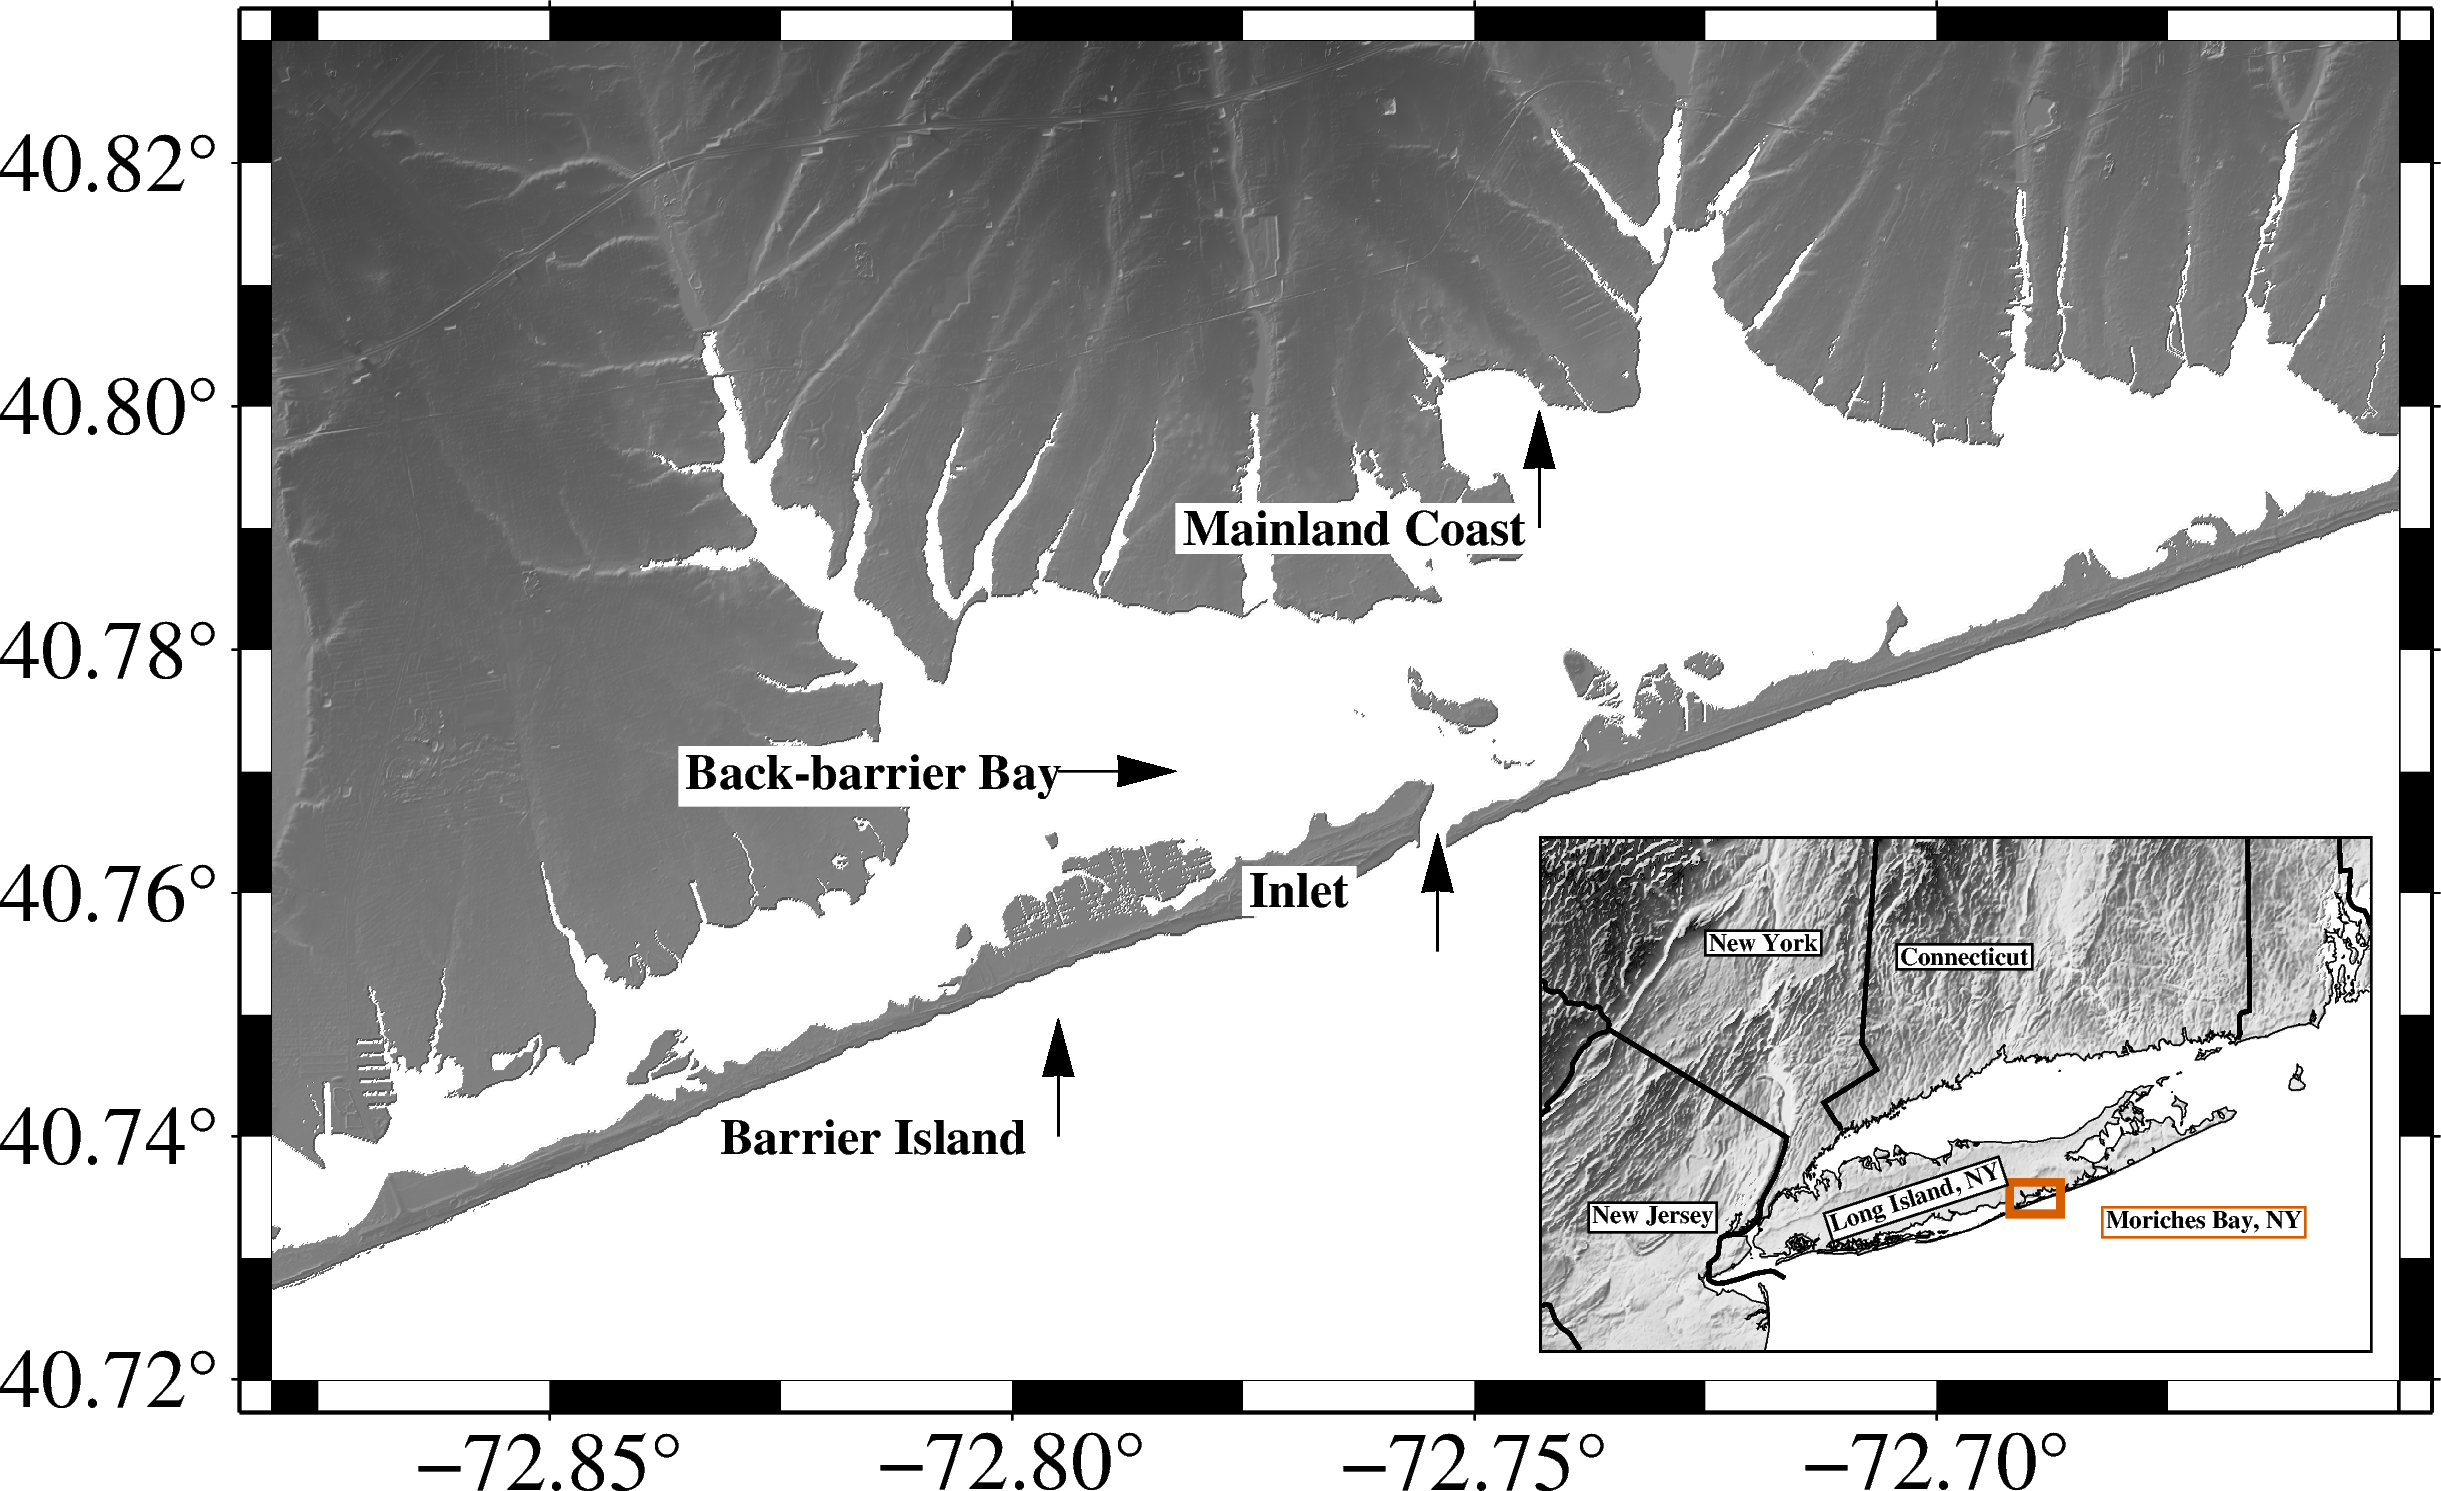

In [46]:
 annot_locs = {'Barrier Island': [-72.8, 40.745-0.005],
                  'Mainland Coast': [-72.7280 - .02, 40.79],
               'Inlet': [-72.7540, 40.7602],
               'Back-barrier Bay': [-72.80, 40.77]
                 }
fig = pygmt.Figure()
with pygmt.config(**map_cfg['region_map']):
    region = map_cfg['moriches_map']['region']
    frame_params = map_cfg['moriches_map']['basemap_frame']
    grid = '/home/catherinej/bathymetry/moriches.nc'
    grd = pygmt.grdclip(grid=grid, below=[0.0, -50])
    dgrid = pygmt.grdgradient(grid=grd, radiance=[100,0])
    fig.basemap(region = region,
                projection = 'M18c',
                frame = frame_params)
    pygmt.makecpt(cmap='gray', series=[-50,50], reverse=True)
    fig.grdimage(grid=grd, cmap=True, shading=True)
    # surge locations

    with pygmt.config(MAP_FRAME_TYPE='plain'):
        with fig.inset(position='jBR+jBR+o.25c/.25c+w7/4.32', box='+pblack'):
            inset_grd = '/home/catherinej/bathymetry/gebco_2020_n45.0_s8.0_w-88.0_e-50.0.nc'
            inset_grid = pygmt.grdclip(grid=inset_grd, below=[0.0, -50])
            inset_region = [-75, -71.25, 40.25, 42]
            fig.basemap(region=inset_region,
                        frame=True,
                       projection='M?',
                       )
            pygmt.makecpt(cmap='gray', series=[-50,500], reverse=True)
            fig.grdimage(grid=inset_grid, cmap=True, shading=True, projection='M?')
            fig.coast( borders=['2/1p,black'],
                      shorelines=True)
            rectangle = [[region[0], region[2], region[1], region[3]]]
            fig.plot(data=rectangle, style='r+s', pen='2p,#D55E00')
            fig.text(x=-72.0, y=40.70, text='Moriches Bay, NY', font='6p,Times-Bold,black', pen='0.5p,#D55E00', fill='white')
            fig.text(x=-73.31, y=40.78, text='Long Island, NY', font='6p,Times-Bold,black', pen='0.5p,black', fill='white', angle=18)
            fig.text(y=40.7178, x=-74.5, text='New Jersey', font='6p,Times-Bold,black', pen='0.5p,black', fill='white')
            fig.text(y=41.65, x=-74., text='New York', font='6p,Times-Bold,black', pen='0.5p,black', fill='white')
            fig.text(y=41.6032, x=-73.0877, text='Connecticut', font='6p,Times-Bold,black', pen='0.5p,black', fill='white')
    for key, data in annot_locs.items():
        if key == 'Inlet':
            fig.text(x=data[0]-0.015, y=data[1], text=key, font='12p,Times-Bold,black', fill='white')
            fig.plot(x=data[0], y=data[1]-0.005, style="v0.5c+e+h0.05", direction=([90], [1]), pen="0.6p", fill="black")
        elif key == 'Back-barrier Bay':
            fig.text(x=data[0]-0.015, y=data[1], text=key, font='12p,Times-Bold,black', fill='white')
            fig.plot(x=data[0]+0.005, y=data[1], style="v0.5c+e+h0.05", direction=([0], [1]), pen="0.6p", fill="black")
        else:  
            fig.text(x=data[0]-0.015, y=data[1], text=key, font='12p,Times-Bold,black', fill='white')
            fig.plot(x=data[0]+0.005, y=data[1], style="v0.5c+e+h0.05", direction=([90], [1]), pen="0.6p", fill="black")


                     
# with pygmt.config(FONT_ANNOT_PRIMARY='18p,Times-Roman'):
#     fig.legend(position='JBR+jBR+o.5c/.45c+w6/3.25',  
#               box=True)
fig.savefig('barrier_island_anatomy.png', transparent=False)
fig.show(width=680)